In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Human Protein Classification with Fastai v1

In [2]:
import os
from pathlib import Path
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from fastai import *
from fastai.vision import *

from utils import open_4_channel
from dataset import ImageMulti4Channel
#from resnet import Resnet4Channel

#from seresnext import *
from pretrainedmodels import se_resnext50_32x4d

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score
from skmultilearn.model_selection import IterativeStratification, iterative_train_test_split
#from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import scipy.optimize as opt

In [3]:
np.random.seed(21)

In [4]:
path = Path('data/')

In [5]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [6]:
df_external = pd.read_csv('external/external.csv')
df_external.head()

,Id,Target
0,10580_1610_C1_1,13 25 0 2 21
1,10580_1610_C1_2,13 25 0 2 21
2,10580_1756_B1_1,13 25 0 2 21
3,10580_1756_B1_2,13 25 0 2 21
4,10580_1758_B1_1,13 25 0 2 21


In [7]:
highest_ratio = df['Target'].value_counts()[df['Target'].value_counts()>1000].index.tolist()

In [8]:
highest_ratio

['0', '25 0', '23', '25', '7', '4', '21']

In [9]:
df_external = df_external[~df_external['Target'].isin(highest_ratio)]

In [10]:
len(df_external)

36291

In [11]:
df_complete = df.append(df_external).reset_index(drop=True)

In [12]:
#df_complete = df_full.sample(frac=0.5).reset_index(drop=True, inplace=True)

In [13]:
len(df), len(df_external), len(df_complete)

(31072, 36291, 67363)

### get better validation split since the classes are very unevenly represented

In [14]:
subcell_locs = {
    0:  "Nucleoplasm", 
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center" ,  
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",
    8:  "Peroxisomes",
    9:  "Endosomes",
    10:  "Lysosomes",
    11:  "Intermediate filaments",   
    12:  "Actin filaments",
    13:  "Focal adhesion sites",   
    14:  "Microtubules",
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",
    18:  "Microtubule organizing center",  
    19:  "Centrosome",
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions", 
    23:  "Mitochondria",
    24:  "Aggresome",
    25:  "Cytosol",
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings" 
}

In [15]:
def plot_ratio(targets):
    labels_num = [value.split() for value in targets]
    labels_num_flat = list(map(int, [item for sublist in labels_num for item in sublist]))
    labels = ["" for _ in range(len(labels_num_flat))]
    for i in range(len(labels_num_flat)):
        labels[i] = subcell_locs[labels_num_flat[i]]

    fig, ax = plt.subplots(figsize=(15, 5))
    pd.Series(labels).value_counts().plot('bar', fontsize=14)

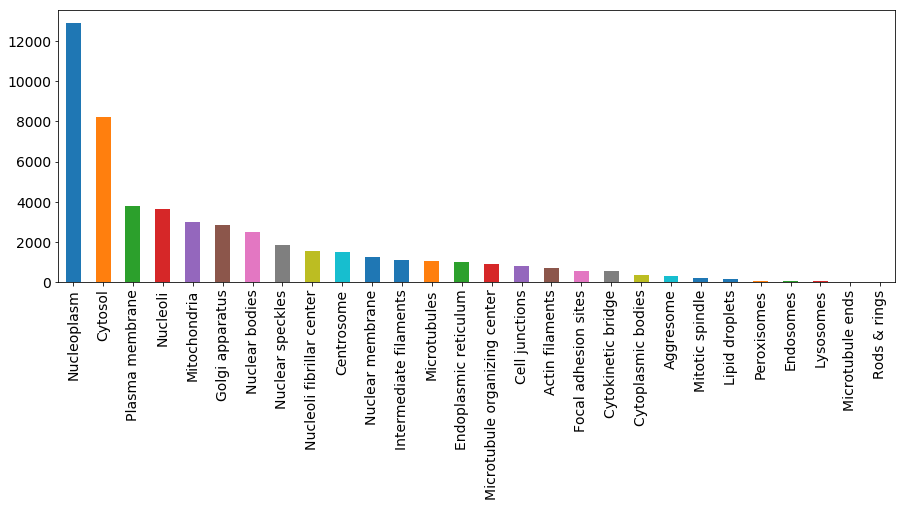

In [16]:
plot_ratio(df['Target'])

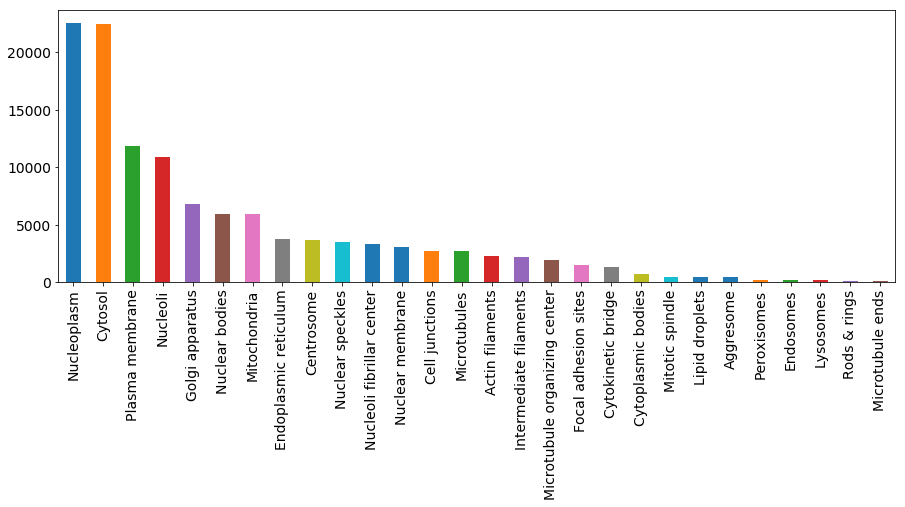

In [17]:
plot_ratio(df_complete['Target'])

In [18]:
#msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42) #random_state=42
#train_df_orig = df.copy()
#
#train_df_orig['Target'] = train_df_orig.apply(lambda x: x['Target'].split(' '), axis=1)
#
#X = train_df_orig['Id'].tolist()
#y = train_df_orig['Target'].tolist()
#y = MultiLabelBinarizer().fit_transform(y)
#
#for train_index, val_index in msss.split(X,y): #it should only do one iteration
#    print("Train:", train_index, "Valid:", val_index)
#
#gc.collect()

In [19]:
class Fold:
    def __init__(self, trn_id, val_id):
        self.train_index = trn_id
        self.val_index = val_id

In [20]:
#k_fold = IterativeStratification(n_splits=5, order=1, random_state=21)
#    
#train_df_orig = df.copy()
#    
#X = train_df_orig['Id'].tolist()
#y = train_df_orig['Target'].tolist()
#y = MultiLabelBinarizer().fit_transform(y)
#folds = []
#
#for train_index, val_index in k_fold.split(X, y):
#    print("Train:", len(train_index), "Valid:", len(val_index))
#    fold = Fold(train_index, val_index)
#    folds.append(fold)
#    #folds[i] = np.append(train_index, val_index)
#   
#del X, y
#gc.collect()

In [21]:
#np.save(path/'folds', folds)

In [22]:
folds = np.load(path/'folds.npy')

In [23]:
train_index = folds[0].train_index
val_index = folds[0].val_index

In [24]:
train_index = np.append(train_index, [i for i in range(len(df), len(df_complete))])
len(train_index), len(val_index), len(df_complete)

(61140, 6223, 67363)

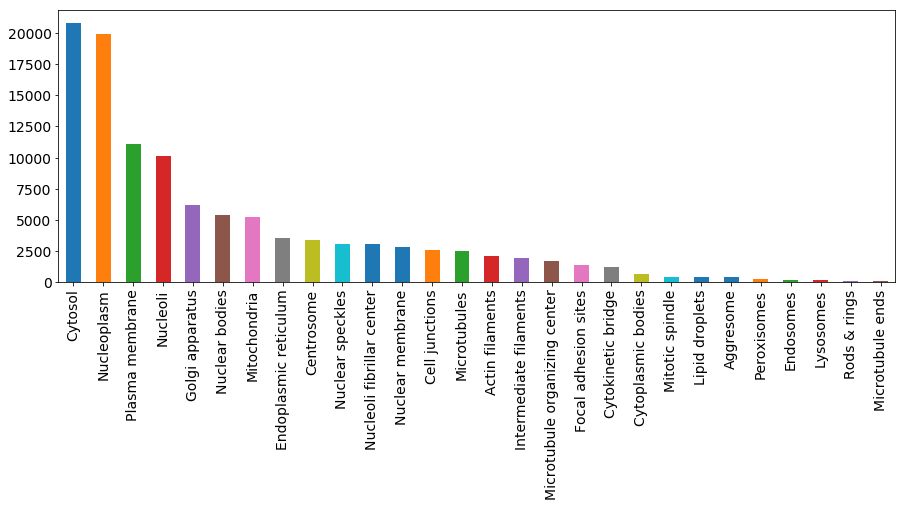

In [25]:
plot_ratio(df_complete.loc[train_index]['Target'])

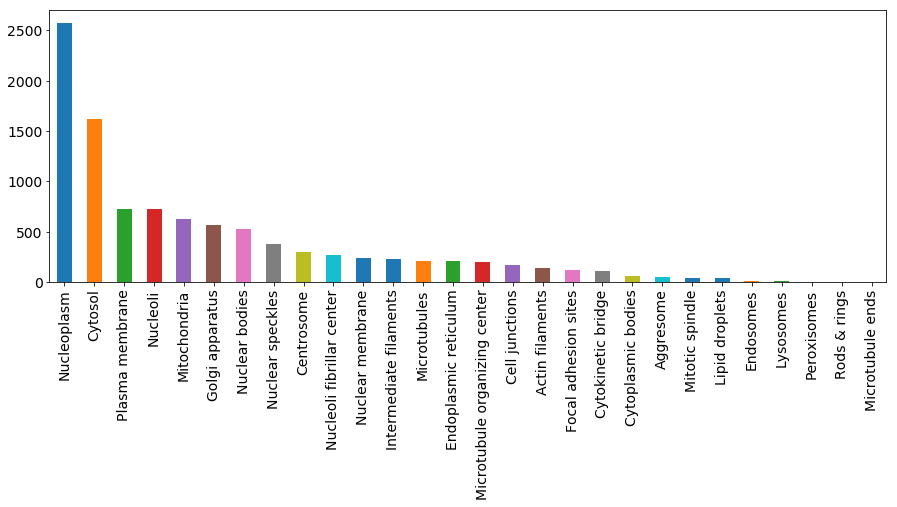

In [26]:
plot_ratio(df_complete.loc[val_index]['Target'])

### set everything we need for creating a ImageMultiDataset

In [27]:
fns = pd.Series([id + '.png' for id in df_complete.Id])
labels = [targ.split(' ') for targ in df_complete.Target]
classes=[str(i) for i in range(28)]

In [28]:
trn_mask=[]

for i in range(len(df_complete)):
    trn_mask.append(False if i in val_index else True)
    
len(trn_mask), trn_mask.count(True), trn_mask.count(False)

(67363, 61140, 6223)

### create train, valid and test ImageMultiDataset

In [29]:
trn_ds, val_ds = ImageMulti4Channel.from_folder_validx(path, 'train', trn_mask, fns, labels, classes=classes)
trn_ds, val_ds

(ImageMulti4Channel of len 61140, ImageMulti4Channel of len 6223)

In [30]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test')}))

In [31]:
test_ds,_ = ImageMulti4Channel.from_folder(
    path, 'test', pd.Series(test_ids),[['0'] for _ in range(len(test_ids))], valid_pct=0, classes=['0'])

### define transforms, normalization and metric

In [32]:
get_transforms

<function fastai.vision.transform.get_transforms(do_flip: bool = True, flip_vert: bool = False, max_rotate: float = 10.0, max_zoom: float = 1.1, max_lighting: float = 0.2, max_warp: float = 0.2, p_affine: float = 0.75, p_lighting: float = 0.75, xtra_tfms: Union[Collection[fastai.vision.image.Transform], NoneType] = None) -> Collection[fastai.vision.image.Transform]>

In [33]:
#trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=10., max_zoom=1.1,
#                      max_lighting=0.2, max_warp=0.2)

In [ ]:
trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1,
                      max_lighting=0.2, max_warp=0.)

In [35]:
#protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

stats_external = ([0.0574, 0.0478, 0.0311, 0.0848], [0.0899, 0.0748, 0.0793, 0.1265]) #without majority classes

#stats_external = ([0.0508, 0.0450, 0.0234, 0.0879], [0.0774, 0.0701, 0.0598, 0.1293]) #with majority classes

### create ImageDataBunch from all this

In [36]:
torch.backends.cudnn.benchmark = True
src_size = 512

In [37]:
bs = 32

In [38]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size//2).normalize(stats_external) #normalization a problem?

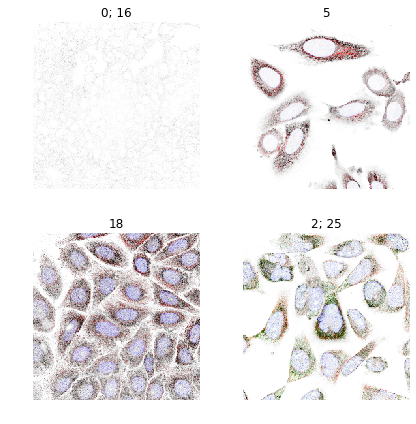

In [39]:
data.show_batch(rows=2, figsize=(6,6), ds_type=DatasetType.Valid)

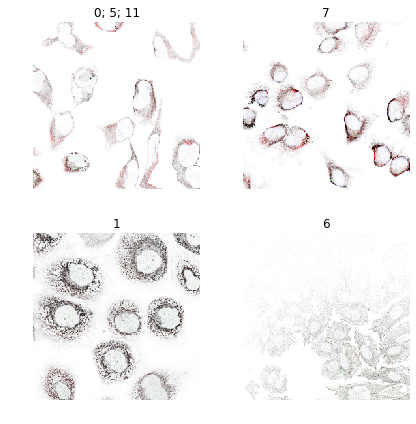

In [40]:
data.show_batch(rows=2, figsize=(6,6))

### create model and learner

In [41]:
#def seresnext50(pretrained=False):
#    return se_resnext50(num_classes=len(classes))

In [42]:
@dataclass
class TrackerCallback(LearnerCallback):
    "A `LearnerCallback` that keeps track of the best value in `monitor`."
    monitor:str='val_loss'
    mode:str='auto'
    
    def __post_init__(self):
        if self.mode not in ['auto', 'min', 'max']:
            warn(f'{self.__name__} mode {self.mode} is invalid, falling back to "auto" mode.')
            self.mode = 'auto'
        mode_dict = {'min': np.less, 'max':np.greater}
        mode_dict['auto'] = np.less if 'loss' in self.monitor else np.greater
        self.operator = mode_dict[self.mode]
    
    def on_train_begin(self, **kwargs:Any)->None:
        self.best = float('inf') if self.operator == np.less else -float('inf')
    
    def get_monitor_value(self):
        values = {'trn_loss':self.learn.recorder.losses[-1:][0].cpu().numpy(),
                  'val_loss':self.learn.recorder.val_losses[-1:][0]}
        for i, name in enumerate(self.learn.recorder.names[3:]):
            values[name]=learn.recorder.metrics[-1:][0][i] 
        if values.get(self.monitor) is None:
            warn(f'{self.__name__} conditioned on metric `{self.monitor}` which is not available. Available metrics are: {", ".join(map(str, self.learn.recorder.names[1:]))}')   
        return values.get(self.monitor)

In [43]:
@dataclass
class SaveModel(TrackerCallback):
    "A `LearnerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()
   
    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                learn.save(f'{self.name}')
    
    def on_train_end(self, **kwargs):
        if self.every=="improvement": learn.load(f'{self.name}')

In [44]:
weights = torch.tensor([0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, \
                        0.4, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2])

#for loss weights: .to(torch.device("cuda"))

In [45]:
f1 = partial(fbeta, thresh=0.4, beta=1) #thresh=weights

In [46]:
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

In [47]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2): #gamma=4 working pretty bad
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

In [48]:
def seresnext50(pretrained=True):
    return se_resnext50_32x4d(num_classes=1000, pretrained='imagenet')

In [49]:
def _seresnext_split(m:nn.Module): return (m[0][3],m[1])

In [50]:
learn = create_cnn(
    data,
    seresnext50,
    ps=0.5,
    cut=-2,
    split_on=_seresnext_split, 
    path=path,    
    metrics=[f1,acc],
    callback_fns=[ShowGraph] #, BnFreeze
)

In [51]:
learn.loss_func = FocalLoss()

In [52]:
learn.loss_func, learn.opt_func

(FocalLoss(),
 functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)))

In [53]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
   (4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
   (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): AdaptiveAvgPool2d(output_size=1)
   (12): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
   (13): ReLU(inplace)
   (14): Conv2d(16, 256, kernel_size=(1, 1), stride=(

In [54]:
learn.freeze()

In [55]:
apply_init(learn.model[1], nn.init.kaiming_normal_)

### use lr find to get a good learning rate

In [56]:
learn.data.train_ds, learn.data.valid_ds

(DatasetTfm(ImageMulti4Channel of len 61140),
 DatasetTfm(ImageMulti4Channel of len 6223))

In [57]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


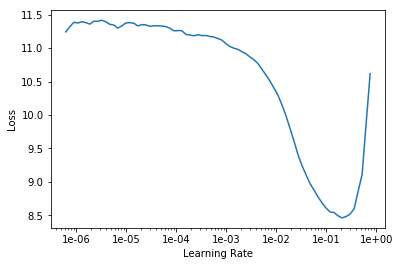

In [58]:
learn.recorder.plot() #seresnext50

In [59]:
lr = 1e-3

### fit the model (half image size)

Total time: 14:23
epoch  train_loss  valid_loss  fbeta  acc        
1      1.277378    1.075633    0.433589  0.951264  (14:23)



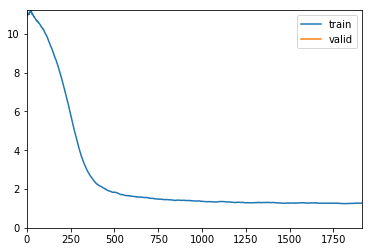

In [60]:
learn.fit_one_cycle(1, max_lr=slice(lr)) # se-resnext50

In [61]:
learn.save('halfsz_seresnext50_frozen')

### unfreeze there resnet layers and train again 

In [49]:
learn.load('halfsz_seresnext50_frozen')

In [62]:
learn.unfreeze()

In [63]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


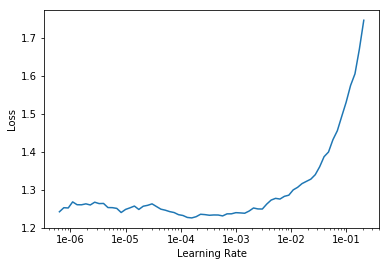

In [64]:
learn.recorder.plot() #se-resnext50 

In [65]:
learn.callback_fns.append(partial(SaveModel, every='improvement', monitor='val_loss'))

In [66]:
#lrs = slice(1e-5, 1e-4) 
lr = 1e-3
lrs = slice(lr/2, lr) 

In [67]:
learn.lr_range(lrs)

array([0.0005  , 0.000707, 0.001   ])

Total time: 5:49:02
epoch  train_loss  valid_loss  fbeta  acc        
1      0.987989    0.816119    0.629852  0.962001  (17:30)
2      0.942876    0.763088    0.666950  0.964406  (17:11)
3      0.916131    0.745438    0.664126  0.965273  (17:12)
4      0.913928    0.783792    0.641186  0.962329  (17:17)
5      0.865699    0.716211    0.678829  0.966215  (17:14)
6      0.883430    0.781804    0.646234  0.963672  (17:14)
7      0.876298    0.733550    0.674158  0.964659  (17:10)
8      0.855218    0.689865    0.688126  0.967506  (17:08)
9      0.826188    0.680036    0.700084  0.967459  (17:13)
10     0.796477    0.643984    0.713752  0.969095  (17:11)
11     0.797819    0.605219    0.736121  0.971190  (17:12)
12     0.757732    0.598970    0.741582  0.971471  (17:13)
13     0.731809    0.576855    0.748014  0.972315  (17:15)
14     0.688604    0.564082    0.754059  0.972636  (17:16)
15     0.645114    0.560232    0.754669  0.973124  (17:10)
16     0.612164    0.553855    0.762709  0.97

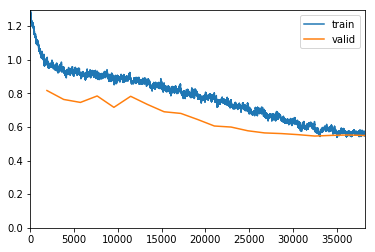

In [68]:
learn.fit_one_cycle(20, max_lr=lrs) # sz 256 se-resnext50

In [69]:
learn.save('halfsz_seresnext50_unfrozen_20e')

### train on whole picture (512px)

In [50]:
bs = 8

In [51]:
data = ImageDataBunch.create(trn_ds, val_ds, test_ds=test_ds, path=path, bs=bs, ds_tfms=(trn_tfms, []), \
                             num_workers=8, size=src_size).normalize(stats_external)

In [52]:
learn = create_cnn(
    data,
    seresnext50,
    ps=0.5,
    cut=-2,
    split_on=_seresnext_split, 
    path=path,    
    metrics=[f1,acc],
    callback_fns=[ShowGraph] #, BnFreeze
)

In [53]:
learn.loss_func = FocalLoss()

In [54]:
learn.layer_groups

[Sequential(
   (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
   (4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
   (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): AdaptiveAvgPool2d(output_size=1)
   (12): Conv2d(256, 16, kernel_size=(1, 1), stride=(1, 1))
   (13): ReLU(inplace)
   (14): Conv2d(16, 256, kernel_size=(1, 1), stride=(

In [55]:
learn.load('bestmodel')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


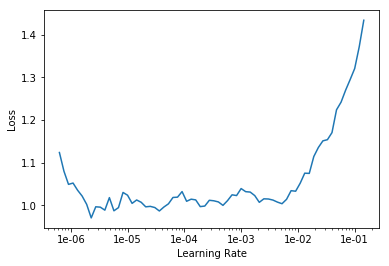

In [ ]:
learn.recorder.plot() #seresnext50 without frozen training 

In [ ]:
learn.callback_fns.append(partial(SaveModel, every='epoch', monitor='val_loss'))

In [ ]:
lr = 1e-4

lrs = slice(lr/2, lr)

In [ ]:
learn.lr_range(lrs)

array([5.000000e-05, 7.071068e-05, 1.000000e-04])

### too low batchsize while normalization is on the whole dataset 
(see: https://stackoverflow.com/questions/45463778/instance-normalisation-vs-batch-normalisation)

epoch,train_loss,valid_loss,fbeta,acc
1,0.876768,0.629380,0.739993,0.971494
2,0.760496,0.564450,0.763840,0.973175
3,0.747732,0.554276,0.770509,0.973371
4,0.725260,0.544371,0.772192,0.974347
5,0.750795,0.549989,0.770914,0.974152
6,0.718213,0.552631,0.768673,0.973802
7,0.686047,0.546804,0.772360,0.974467
8,0.657204,0.584595,0.755841,0.972957
9,0.676604,0.545541,0.769352,0.974094
10,0.641453,0.545747,0.771350,0.974197


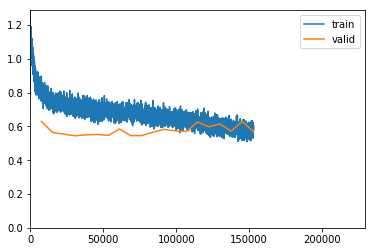

In [ ]:
learn.fit_one_cycle(30, lrs) #1e-4 slice(lr/2, lr/1) seresnext50

In [ ]:
learn.save('fullsz_seresnext50_unfrozen_30e')

epoch,train_loss,valid_loss,fbeta,acc
1,0.805744,0.588103,0.754351,0.972968
2,0.730955,0.547481,0.767286,0.973553
3,0.714415,0.546111,0.762619,0.973828
4,0.730338,0.528607,0.780767,0.974573
5,0.700665,0.533281,0.773417,0.974849
6,0.673815,0.548966,0.763912,0.974080
7,0.653720,0.545299,0.769084,0.974115
8,0.632263,0.576289,0.752925,0.972979
9,0.691078,0.543628,0.775221,0.975147
10,0.661994,0.552647,0.768972,0.974126


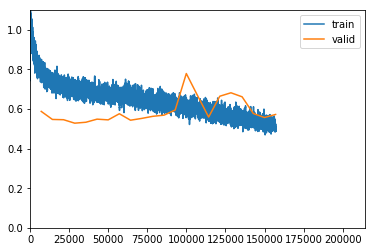

KeyboardInterrupt: 

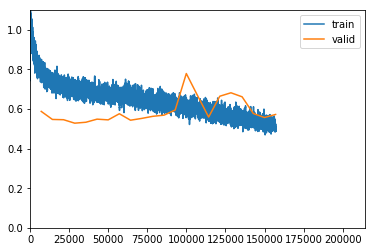

In [57]:
learn.fit_one_cycle(30, lrs) #1e-4 slice(lr/2, lr/1) seresnext50

In [ ]:
## this was really solid:

Total time: 21:17:08
epoch  train_loss  valid_loss  fbeta  acc        
1      0.757835    0.548488    0.758754  0.973759  (40:21)
2      0.746657    0.546122    0.762647  0.973885  (40:13)
3      0.720824    0.563070    0.758718  0.973518  (40:18)
4      0.745658    0.560160    0.759263  0.973174  (41:41)
5      0.743314    0.595286    0.737035  0.971866  (40:41)
6      0.754175    0.584874    0.746192  0.972303  (40:25)
7      0.796534    0.584026    0.739114  0.972681  (40:31)
8      0.799962    0.589762    0.743158  0.972039  (40:26)
9      0.765086    0.581272    0.744766  0.971637  (40:25)
10     0.803857    0.599986    0.744068  0.971511  (40:11)
11     0.771217    0.586461    0.745711  0.972153  (40:11)
12     0.741829    0.604694    0.756416  0.972302  (40:11)
13     0.732379    0.602741    0.753963  0.971591  (40:10)
14     0.705828    0.571108    0.750331  0.972990  (40:13)
15     0.671297    0.546377    0.763997  0.973989  (40:15)
16     0.707839    0.536943    0.767141  0.9

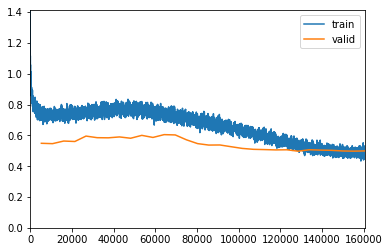

In [55]:
learn.fit_one_cycle(30, lrs) #1e-4 slice(lr/2, lr/1) resnet50 externalmix 0.1 valid

## try to improve best model 

In [50]:
learn.load('bestmodel')

In [51]:
learn.unfreeze()

In [52]:
learn.lr_find(num_it=500)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


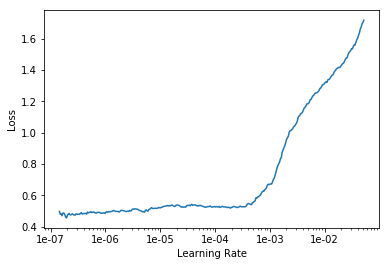

In [53]:
learn.recorder.plot() 

In [54]:
lr = 1e-4

lrs = slice(lr/2, lr)

In [55]:
learn.lr_range(lrs)

array([5.000000e-05, 7.071068e-05, 1.000000e-04])

In [56]:
learn.callback_fns.append(partial(SaveModel, every='epoch', monitor='val_loss'))

In [ ]:
learn.fit_one_cycle(4, lrs) #1e-4 slice(lr/2, lr/1) same split

epoch,train_loss,valid_loss,fbeta,acc


In [ ]:
learn.save('with_external/best/bestmodel_externalres50_4E')

### Try to find a good Threshold

In [90]:
#learn.load('best/bestmodel_externalres50')
learn.load('bestmodel_16')

In [91]:
learn.model.eval()

Sequential(
  (0): Sequential(
    (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [92]:
preds, y = learn.get_preds(DatasetType.Valid)

In [93]:
preds_tta,y = learn.TTA(ds_type=DatasetType.Valid)

Total time: 05:35



In [94]:
preds.shape, preds_tta.shape

(torch.Size([3114, 28]), torch.Size([3114, 28]))

In [95]:
act_preds = torch.sigmoid(preds)

act_preds_tta = torch.sigmoid(preds_tta)

In [96]:
ensamble = act_preds * 0.2 + act_preds_tta * 0.8

In [97]:
#np.set_printoptions(suppress=True)

In [98]:
act_preds[0].round(), y[0]

(tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [99]:
weights = torch.tensor([0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.2, 0.4, \
                        0.4, 0.4, 0.4, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2])

### optimize with sklearn

In [100]:
#fb = partial(fbeta, ensamble, y, sigmoid=False)

In [101]:
from scipy.optimize import minimize, fmin
import sklearn.metrics as m

In [102]:
def f1_thresh(thresh):
    return -m.f1_score((ensamble.numpy()>thresh), y.numpy(), average='macro')

In [313]:
thresh = fmin(f1_thresh, weights)

Optimization terminated successfully.
         Current function value: -0.714276
         Iterations: 199
         Function evaluations: 527


In [314]:
thresh

array([0.499222, 0.399941, 0.397451, 0.403361, 0.403288, 0.403075, 0.400338, 0.397777, 0.200438, 0.200191, 0.200548,
       0.40017 , 0.405702, 0.399414, 0.398426, 0.19977 , 0.401261, 0.39964 , 0.391047, 0.401425, 0.200328, 0.39959 ,
       0.402193, 0.400174, 0.400562, 0.399886, 0.411349, 0.19986 ])

In [315]:
f1_thresh(thresh)

-0.7142762485930101

In [316]:
f1_thresh(weights.numpy())

-0.7113881694856058

In [317]:
#res = minimize(f1_thresh, weights, method='nelder-mead',
#               options={'xtol': 1e-8, 'disp': True})

In [318]:
fbeta(act_preds_tta, y, thresh=torch.from_numpy(thresh*0.845).float(), sigmoid=False)

tensor(0.8296)

### predict test set 

In [319]:
preds_t,y_t = learn.get_preds(DatasetType.Test)

In [323]:
preds_t_tta,y_t = learn.TTA(ds_type=DatasetType.Test)

Total time: 19:04



In [350]:
act_preds_t = torch.sigmoid(preds_t)

act_preds_t_tta = torch.sigmoid(preds_t_tta)

In [351]:
act_preds_t[0].round(), act_preds_t_tta[0].round()

(tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [352]:
act_preds_t.shape, act_preds_t_tta.shape

(torch.Size([11702, 28]), torch.Size([11702, 28]))

In [353]:
tuned_weights = (weights*0.85).numpy()
#tuned_weights = thresh  #*0.92
tuned_weights

array([0.425, 0.34 , 0.34 , 0.34 , 0.34 , 0.34 , 0.34 , 0.34 , 0.17 , 0.17 , 0.17 , 0.34 , 0.34 , 0.34 , 0.34 , 0.17 ,
       0.34 , 0.34 , 0.34 , 0.34 , 0.17 , 0.34 , 0.34 , 0.34 , 0.34 , 0.34 , 0.34 , 0.17 ], dtype=float32)

In [354]:
ensamble_t = act_preds_t * 0.2 + act_preds_t_tta * 0.8

In [355]:
#pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.327)[0]])) \
#               for row in np.array(ensamble_t)]

pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>tuned_weights)[0]])) \
               for row in np.array(ensamble_t)]

### replace empty predicitons with highest probability

In [356]:
indices = [i for i, x in enumerate(pred_labels) if x == '']

In [357]:
for ind in indices: 
    pred_labels[ind] = \
    ' '.join(list([str(i) for i in np.nonzero(act_preds_t_tta[ind].numpy()>tuned_weights*0.85)[0]]))
    #print(pred_labels[ind])

In [360]:
indices = [i for i, x in enumerate(pred_labels) if x == '']

In [361]:
for ind in indices:
    act_preds_t_tta[ind]
    _max = torch.max(act_preds_t_tta[ind])
    argmax = ((act_preds_t_tta[ind] == _max).nonzero())
    pred_labels[ind] = str(argmax.numpy()[0][0])

### create submission and replace the leaked prediction for leaderboard comparison

In [362]:
sub = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})

In [363]:
len(sub['Predicted'][sub['Predicted']==''])

0

In [364]:
#test_matches = pd.read_csv(path/'test_matches.csv')

In [365]:
#test_matches.head()

,Extra,Test,SimR,SimG,SimB,Target,Target_noisey
0,ENSG00000001497_44431_556_B9_1,7729b27c-bacc-11e8-b2b8-ac1f6b6435d0,10,6,2,25 18 0,NaN
1,ENSG00000006194_35086_383_E8_7,5661665e-bacf-11e8-b2b8-ac1f6b6435d0,0,0,0,25 17 0,NaN
2,ENSG00000008324_47377_688_E7_10,b029f372-bad9-11e8-b2b9-ac1f6b6435d0,2,0,2,23 2,NaN
3,ENSG00000019186_63771_1414_D12_2,adc182fa-bad2-11e8-b2b8-ac1f6b6435d0,6,2,0,23 0 21,NaN
4,ENSG00000025770_67932_1255_A3_4,39508fe6-bad3-11e8-b2b8-ac1f6b6435d0,0,0,0,16 0,NaN


In [366]:
#for _, row in test_matches.iterrows():
#    print(sub[sub.Id == row.Test].Predicted)
#    sub['Predicted'][sub.Id == row.Test] = row.Target
#    print(sub[sub.Id == row.Test].Predicted)

5419    0 18 25
Name: Predicted, dtype: object
5419    25 18 0
Name: Predicted, dtype: object
3901    17 25
Name: Predicted, dtype: object
3901    25 17 0
Name: Predicted, dtype: object
8073    23 25
Name: Predicted, dtype: object
8073    23 2
Name: Predicted, dtype: object
7947    0 21 25
Name: Predicted, dtype: object
7947    23 0 21
Name: Predicted, dtype: object
2571    0 16
Name: Predicted, dtype: object
2571    16 0
Name: Predicted, dtype: object
7569    9 10
Name: Predicted, dtype: object
7569    9 10
Name: Predicted, dtype: object
2214    0 14 16 25
Name: Predicted, dtype: object
2214    14 0
Name: Predicted, dtype: object
1838    14 25
Name: Predicted, dtype: object
1838    14
Name: Predicted, dtype: object
9721    14 16
Name: Predicted, dtype: object
9721    14
Name: Predicted, dtype: object
6119    0 16
Name: Predicted, dtype: object
6119    0
Name: Predicted, dtype: object
783    0 16
Name: Predicted, dtype: object
783    21
Name: Predicted, dtype: object
9781    7
Name: Pr

7303    14
Name: Predicted, dtype: object
7198    12 25
Name: Predicted, dtype: object
7198    12 2
Name: Predicted, dtype: object
8754    0 4
Name: Predicted, dtype: object
8754    4 21
Name: Predicted, dtype: object
5466    0 2
Name: Predicted, dtype: object
5466    0
Name: Predicted, dtype: object
9881    0 12
Name: Predicted, dtype: object
9881    12
Name: Predicted, dtype: object
4592    2
Name: Predicted, dtype: object
4592    2
Name: Predicted, dtype: object
10215    4
Name: Predicted, dtype: object
10215    18 17
Name: Predicted, dtype: object
4345    0 11 23
Name: Predicted, dtype: object
4345    23
Name: Predicted, dtype: object
6479    0 16 25
Name: Predicted, dtype: object
6479    0
Name: Predicted, dtype: object
1108    1
Name: Predicted, dtype: object
1108    1 0
Name: Predicted, dtype: object
10394    0 13
Name: Predicted, dtype: object
10394    13
Name: Predicted, dtype: object
7993    0 1 13 21 25
Name: Predicted, dtype: object
7993    13
Name: Predicted, dtype: object

406    25 20
Name: Predicted, dtype: object
11535    0 20 23
Name: Predicted, dtype: object
11535    25 20
Name: Predicted, dtype: object
8265    0 16
Name: Predicted, dtype: object
8265    16 0
Name: Predicted, dtype: object
8782    19
Name: Predicted, dtype: object
8782    19
Name: Predicted, dtype: object
9047    0 2
Name: Predicted, dtype: object
9047    2 21
Name: Predicted, dtype: object
5299    7 25
Name: Predicted, dtype: object
5299    25 7
Name: Predicted, dtype: object
4162    0 4
Name: Predicted, dtype: object
4162    0
Name: Predicted, dtype: object
5013    5
Name: Predicted, dtype: object
5013    5
Name: Predicted, dtype: object
1184    0 16
Name: Predicted, dtype: object
1184    16 14 17 0
Name: Predicted, dtype: object
9871    1
Name: Predicted, dtype: object
9871    25 1
Name: Predicted, dtype: object
6330    0 5 25
Name: Predicted, dtype: object
6330    25
Name: Predicted, dtype: object
7539    23
Name: Predicted, dtype: object
7539    23
Name: Predicted, dtype: objec

In [367]:
sub.to_csv(path/'resnet50.csv', header=True, index=False)

In [368]:
pred_labels

['2',
 '5 25',
 '0 5 25',
 '0 25',
 '2 20 23 25',
 '4 25',
 '0 4 21 23 25',
 '0 25',
 '0',
 '4 25',
 '5 7 25',
 '3 5',
 '2 25',
 '7 25',
 '25',
 '4 5 23 25',
 '2 25',
 '0 5',
 '14',
 '0 5',
 '1 6 25',
 '2 25',
 '0 21 25',
 '0 21',
 '0 4',
 '0 21 23 25',
 '0',
 '0 1',
 '0 25',
 '0 5',
 '2 13 21',
 '0 7 19',
 '17 18',
 '5',
 '0 7 25',
 '13',
 '0 19 25',
 '3',
 '21 25',
 '1',
 '0 25',
 '6',
 '0 7 21',
 '19 25',
 '21 25',
 '6 20 25',
 '0',
 '0 21',
 '6 23',
 '0',
 '7 25',
 '0 5',
 '20',
 '25',
 '3',
 '0 23',
 '0 25',
 '11',
 '0 25',
 '25',
 '2 20',
 '0 5 21',
 '14 25',
 '5 21 25',
 '23 25',
 '0 25',
 '3 6 25',
 '0',
 '0 16',
 '5 25',
 '2',
 '0 2 25',
 '14',
 '4',
 '21',
 '0',
 '0 4',
 '0 1 21',
 '0 25',
 '0 25',
 '0 25',
 '0 25',
 '0 5 21 25',
 '21 25',
 '18 19',
 '0 5 25',
 '23',
 '0 21',
 '25',
 '14 25',
 '0 25',
 '11',
 '23',
 '12 13',
 '23 25',
 '0 21 25',
 '19 25',
 '0 7 25',
 '24',
 '0 23 25',
 '25',
 '3 23',
 '2 23',
 '0 23',
 '6',
 '3 21 22 25',
 '0 14 16',
 '0 7 11 25',
 '20 25',
